# Connect4 Game Detection

This notebook details how to detect the state of a connect4 game from an image. The game is played on a 7x6 grid, with two players, red and yellow. The players take turns dropping a piece into one of the columns, and the first player to get 4 in a row wins. The game can end in a draw if the board is filled without a winner.

## Load in libraries

In [ ]:
#%pip install opencv-python
#%pip install matplotlib
#%pip install numpy
#%pip install scikit-learn

## Load in the image

### From File

Pick the image using the file picker below. The image should be a screenshot of the game, with the board fully visible. The board should be centered in the image, and the board should be the only thing in the image.

Dropdown(description='Select Image', options=('images/connect4_1.jpg', 'images/connect4_10.jpg', 'images/conne…

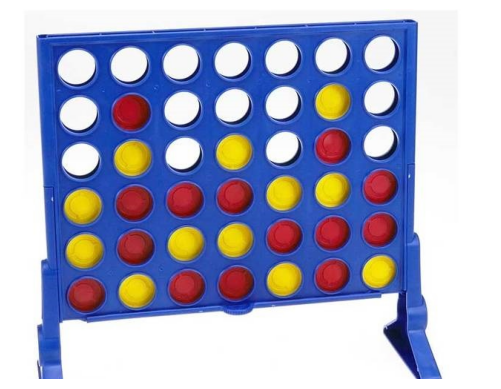

In [3]:
# Create a dropdown menu to select the image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import os
import cv2
import matplotlib.pyplot as plt

# Global values for the image.
img_path = 'images/connect4_1.jpg'
img = cv2.imread(img_path)

# Display the selected image.
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Update the image variable when the dropdown menu is changed.
def update_image(change):
    global img_path, img

    clear_output()
    display(dropdown)
    img_path = change.new
    img = cv2.imread(img_path)
    display_image(img)

# Get a list of all the images in the images folder. Keep the path in front of the image name.
image_names = ['images/' + image_name for image_name in os.listdir('images/')]

# Create the dropdown menu
dropdown = widgets.Dropdown(options=image_names, description='Select Image')
dropdown.observe(update_image, names='value')
display(dropdown)
display_image(img)


### From Webcam

Button(description='Webcam Image', style=ButtonStyle())

Getting image from webcam...


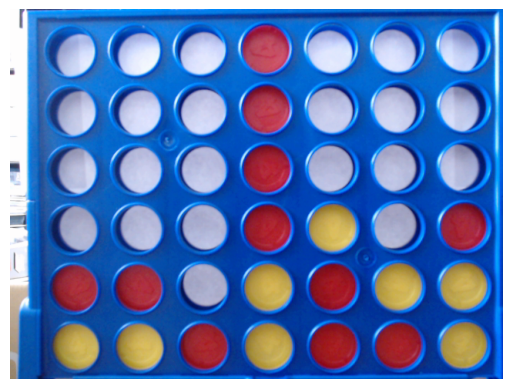

In [4]:
import cv2
from ipywidgets import interact, widgets

# Open webcam and get the cv2 image from it.
def get_webcam_image():
    cap = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
    _, frame = cap.read()
    cap.release()
    return frame

# Get the image from the webcam and display it.
def get_webcam_image_and_display(_):
    global img
    print('Getting image from webcam...')
    img = get_webcam_image()
    display_image(img)
    return img

# Create the button to get the image from the webcam.
button = widgets.Button(description='Webcam Image')
button.on_click(get_webcam_image_and_display)
display(button)

## Preprocess Image

Crop the image to only include the board. This is done so that there is less noise in the image, and the model can focus on the board.

Currently the image is cropped manually, but in the future this could be done automatically, or we could add crosshairs in the camera view to help the user center the board.

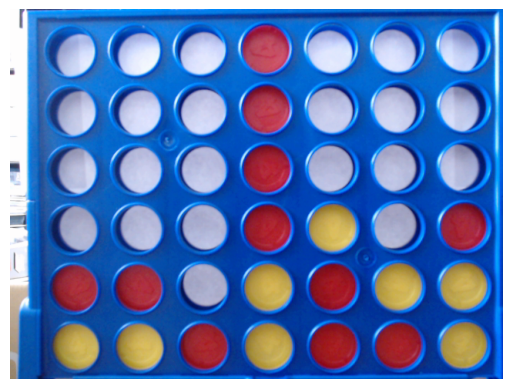

In [5]:
import scaler

# Scale the image down to a smaller size for easier processing.
scaler = scaler.Scaler(img, scale_limit=1000)
scaler.scale_image()
img = scaler.get_scaled_image()
display_image(img)

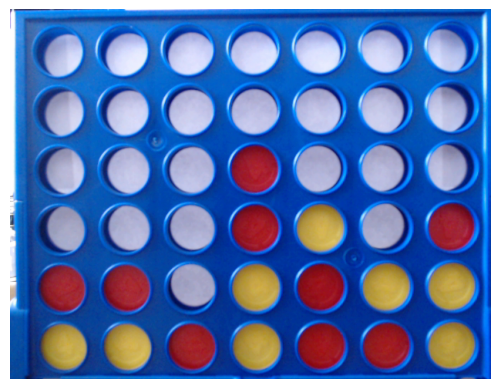

In [4]:
import cropper

# Create a cropper object and crop the image
cropper = cropper.Cropper(img)
cropper.crop_image() # blocking call
img = cropper.get_cropped_image()
display_image(img)

# Close all open windows
cv2.destroyAllWindows()

## Detect the grid circles

### Radius Definition

Determine the radius of the circles to search for based on a cropped image of the board. We just take half the distance of the largest dimention of the cropped image.

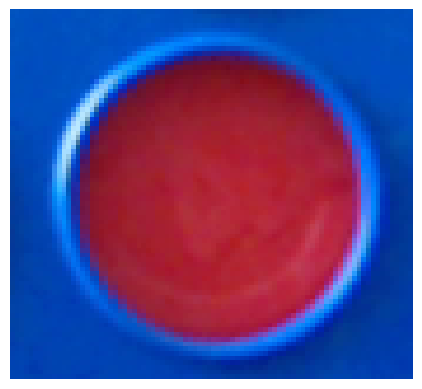

Width of the piece:  86
Height of the piece:  79
Radius of the piece:  43


In [7]:
import cropper

cropper = cropper.Cropper(img)
cropper.crop_image() # blocking call
crop_img = cropper.get_cropped_image()
display_image(crop_img)

width = crop_img.shape[1]
height = crop_img.shape[0]
print("Width of the piece: ", width)
print("Height of the piece: ", height)

radius = max(width, height) / 2
radius = int(radius)
print("Radius of the piece: ", radius)


In [8]:
import numpy as np

def circles_overlap(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance < (r1 + r2)

def remove_overlapping_circles(circles):
    non_overlapping_circles = []
    for circle in circles:
        overlap = False
        for other_circle in non_overlapping_circles:
            if circles_overlap(circle, other_circle):
                overlap = True
                if circle[2] < other_circle[2]:  # If current circle is smaller, replace the other_circle
                    non_overlapping_circles.remove(other_circle)
                    non_overlapping_circles.append(tuple(circle))
                break
        if not overlap:
            non_overlapping_circles.append(tuple(circle))
    return non_overlapping_circles


c:\Users\hilly\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hilly\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


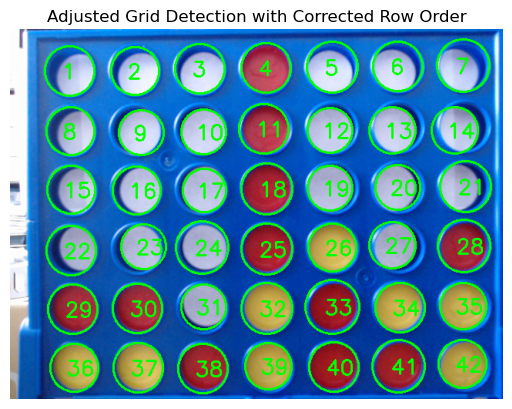

In [9]:
# Import KMeans from sklearn
from sklearn.cluster import KMeans

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Set minimum and maximum radius of the circles to detect
radius_delta = 15
min_radius = radius - radius_delta
max_radius = radius + radius_delta
average_radius = (min_radius + max_radius) / 2
average_radius = int(average_radius)

# Use Hough Transform to detect circles
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=average_radius, param1=200, param2=20,
                           minRadius=min_radius, maxRadius=max_radius)
if circles is None:
    raise ValueError('No circles found!')
# if len(circles[0]) != 42:
#     raise ValueError('Incorrect number of circles found!')

# Convert circles to list of tuples and remove overlapping circles
circles_list = [tuple(circle) for circle in circles[0]]
non_overlapping_circles = remove_overlapping_circles(circles_list)
circles = np.array([non_overlapping_circles])


# Cluster the y-coordinates to determine distinct rows
kmeans = KMeans(n_clusters=6)  # Assuming 6 rows in Connect 4
y_coords = circles[0][:, 1].reshape(-1, 1)
kmeans.fit(y_coords)

# Get and sort the cluster centers
sorted_centers = sorted([(center[0], idx) for idx, center in enumerate(kmeans.cluster_centers_)])

# Create a mapping from original cluster label to sorted order
label_map = {original_idx: sorted_idx for sorted_idx, (_, original_idx) in enumerate(sorted_centers)}

# Use the label_map to get labels in sorted order
labels = [label_map[label] for label in kmeans.labels_]

# Sort by the new labels (rows) and then by x-coordinate within each row
sorted_circles = [circle for _, circle in sorted(zip(labels, circles[0]), key=lambda c: (c[0], c[1][0]))]

# Create a new image for visualization
vis_img = img_rgb.copy()

# Draw the sorted circles on the image and annotate with their grid position
for idx, (x, y, r) in enumerate(sorted_circles):
    x, y, r = int(x), int(y), int(r)
    cv2.circle(vis_img, (x, y), r, (0, 255, 0), 2)  # draw the circle in green
    text = str(idx + 1)
    cv2.putText(vis_img, text, (x - 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with sorted circles
plt.imshow(vis_img)
plt.title('Adjusted Grid Detection with Corrected Row Order')
plt.axis('off')
plt.show()


## Detect the pieces

### Define Pixel Colors

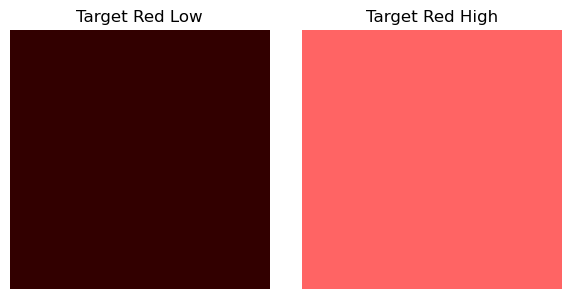

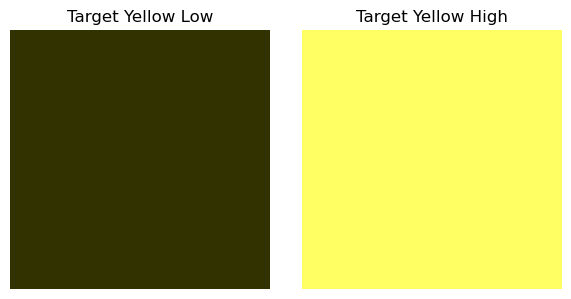

In [10]:
# Define color boundaries
red_low = np.array([50, 0, 0])
red_high = np.array([255, 100, 100])
yellow_low = np.array([50, 50, 0])
yellow_high = np.array([255, 255, 100])

def display_colors(color_low, color_high, color_name):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.full((50, 50, 3), color_low), vmin=0, vmax=255)
    plt.title(f'Target {color_name} Low')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(np.full((50, 50, 3), color_high), vmin=0, vmax=255)
    plt.title(f'Target {color_name} High')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

display_colors(red_low, red_high, 'Red')
display_colors(yellow_low, yellow_high, 'Yellow')

### Detect Piece Positions

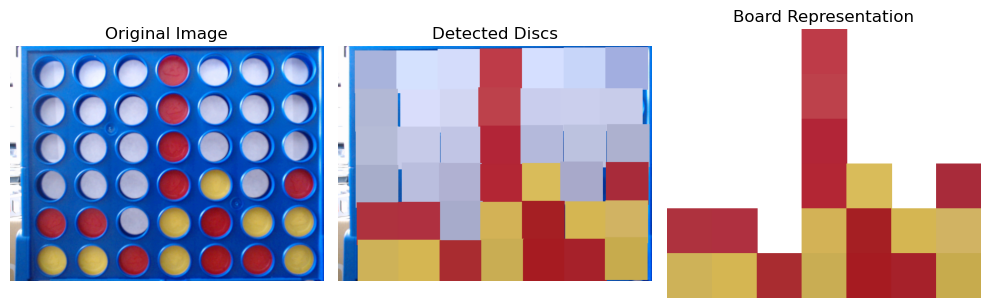

[['O' 'O' 'O' 'R' 'O' 'O' 'O']
 ['O' 'O' 'O' 'R' 'O' 'O' 'O']
 ['O' 'O' 'O' 'R' 'O' 'O' 'O']
 ['O' 'O' 'O' 'R' 'Y' 'O' 'R']
 ['R' 'R' 'O' 'Y' 'R' 'Y' 'Y']
 ['Y' 'Y' 'R' 'Y' 'R' 'R' 'Y']]


In [12]:
board = []

# Create a blank white image for board representation
board_img = np.ones((300, 350, 3), dtype=np.uint8) * 255  # Assuming 50x50 pixels per cell

for idx, (x, y, r) in enumerate(sorted_circles):
    x, y, r = int(x), int(y), int(r)
    pixel = img_rgb[y, x]
    int_pixel = tuple(map(int, pixel))
    
    # Draw the sampled pixel using the integer values
    cv2.rectangle(vis_img, (x-average_radius, y-average_radius), (x+average_radius, y+average_radius), int_pixel, -1)
    
    # Determine the disc color and fill the corresponding position in board_img with the actual pixel color
    row = idx // 7
    col = idx % 7
    if np.all((red_low <= pixel) & (pixel <= red_high)):
        board.append('R')
        cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)
    elif np.all((yellow_low <= pixel) & (pixel <= yellow_high)):
        board.append('Y')
        cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)
    else:
        board.append('O')
        # cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)

# Display the visualization image with detected discs
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(vis_img)
plt.title('Detected Discs')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(board_img)
plt.title('Board Representation')
plt.axis('off')
plt.tight_layout()
plt.show()

# Assuming a 6x7 board for Connect 4
board_matrix = np.array(board).reshape(6, 7)
print(board_matrix)


## Determine the winner

In [10]:
def check_winner(board):
    patterns = ['RRRR', 'YYYY']
    
    # Check rows
    for row in board:
        for pattern in patterns:
            if pattern in ''.join(row):
                return pattern[0]
                
    # Check columns
    for col in board.T:
        for pattern in patterns:
            if pattern in ''.join(col):
                return pattern[0]

    # Check diagonals
    diagonals = [board.diagonal(i) for i in range(-3, 4)]
    antidiagonals = [np.fliplr(board).diagonal(i) for i in range(-3, 4)]
    for diagonal in diagonals + antidiagonals:
        for pattern in patterns:
            if pattern in ''.join(diagonal):
                return pattern[0]
    return None

winner = check_winner(board_matrix)
if winner == 'R':
    print("Red wins!")
elif winner == 'Y':
    print("Yellow wins!")
else:
    print("No winner yet!")


No winner yet!
